# Ejercicio resuelto en clase. Atari: Assault

### En esta versión intentamos entrenar en batch en vez de 1 a 1

In [33]:
import sys

sys.version

'3.10.13 (main, Sep 11 2023, 13:21:10) [GCC 11.2.0]'

In [34]:
import gymnasium as gym
import matplotlib.pyplot as plt
from keras import layers, Model
import keras
import numpy as np
import tensorflow as tf
from collections import deque
import random

((210, 160), {'lives': 4, 'episode_frame_number': 0, 'frame_number': 0})

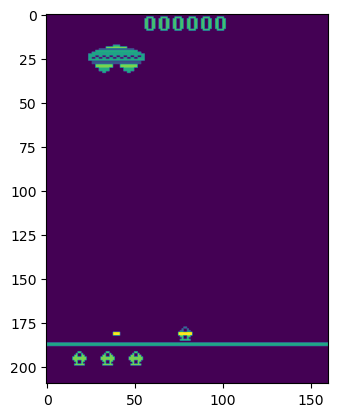

In [35]:
gym_name = "ALE/Assault-v5"
env = gym.make(gym_name, obs_type="grayscale")
s0, info = env.reset()


plt.imshow(s0)
s0.shape, info

Probar episodio random

In [36]:
def state_to_tensor(state):
    state = tf.convert_to_tensor(state)
    state = tf.expand_dims(state, 0)
    return state

In [37]:
def create_q_model():
    # Definir el tamaño de los inputs
    inputs = layers.Input(shape=(*s0.shape, 1))

    #Definir la red neuronal

    layer1 = layers.Conv2D(32, 8, strides=4, activation='relu')(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation='relu')(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation='relu')(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(128, activation='relu')(layer4)
    action = layers.Dense(env.action_space.n, activation='linear')(layer5)

    return keras.Model(inputs=inputs, outputs=action)
    

Doble DQN

In [38]:
decay = 0.9999
epsilon_ini = 1.0
epsilon_end = 0.05
learning_rate = 0.001
gamma = 0.999
max_memory_size = int(10e5)
batch_size = 16


In [39]:
import keras.optimizers


q_model = create_q_model()
t_model = create_q_model()

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
q_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 210, 160, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 51, 39, 32)        2080      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 18, 64)        32832     
                                                                 
 conv2d_14 (Conv2D)          (None, 22, 16, 64)        36928     
                                                                 
 flatten_4 (Flatten)         (None, 22528)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               2883712   
                                                                 
 dense_9 (Dense)             (None, 7)                 903 

Elegir mejor acción

In [40]:
def get_best_action(state):
    q_state = q_model(state)
    return np.argmax(q_state)

Elegir parámetros

In [41]:
# Esto no sé para qué se hace

s0_b = np.expand_dims(s0, axis=0)
q0_b = q_model(s0_b)
q0_b

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[ 0.7763389 , -0.6896173 ,  1.4390453 ,  1.0300586 , -0.08347991,
        -1.1862223 , -1.7574601 ]], dtype=float32)>

Tensorboard

In [42]:
import datetime
import os

implementation = 'DQN_ATARI_ASSAULT_V0'
current_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
train_log_dir = os.path.join('logs', gym_name, implementation, 'T_' + current_time)
summary_writer = tf.summary.create_file_writer(train_log_dir)

In [43]:
%reload_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 8726), started 0:07:22 ago. (Use '!kill 8726' to kill it.)

# Entrenar al modelo (bucle principal)
1. Resetear environment
2. Generar experiencias hasta terminar el episodio
3. Tras generar el episodio, hay que entrenar

### Cosas que añadimos para que el modelo sea más rápido:
- Contador para entrenar solo cada 10 pasos

In [44]:
memory = deque(maxlen=max_memory_size)

episode = 0
epoque = 0
epsilon = epsilon_ini
agent_eval = 0
goal = 500

while True:
    #Begin episode
    s0, info = env.reset()
    #Convertimos s0 a las dimensiones que necesitamos
    s0_b = np.expand_dims(s0, axis=0)
    steps = 0
    #El próximo bucle es el generador de experiencias. Aquíe también entrenamos(se puede entrenar en otros sitios, pero elegimos entrenar tras cada acción.)
    while True:
        #Select action
        #Cómo actuamos con epsilon greedy, sacamos un número al azar de 0 a 1.
        if np.random.random() < epsilon:
            #Si es menor que el epsilon, elegiremos una acción al azar
            action = env.action_space.sample()
        else:
            #Si es mayor que el epsilon, elegiremos la mejor acción según el modelo
            q0_b = q_model(s0_b) #Esto, loq ue hace es pasar el estado actual como input al modelo y obtenemos un tensor con la probabilidad de cada acción
            action = np.argmax(q0_b)
        
        #Ajustar el epsilon. Hay estudiar las mejores técnicas para esto. Por ejemplo, si ves que olvidas, se puede aumentar el epsilon
        if epsilon > epsilon_end:
            epsilon *= decay
        else:
            epsilon = epsilon_end
        #Una vez elegida la acción hacemos el próximo paso con el método step.
        next_state, reward, terminated, truncated, info = env.step(action)
        next_state = np.expand_dims(next_state, axis=0)

        steps += 1
        #Guardar la experiencia
        experience = (s0_b, action, next_state, reward, terminated, truncated)
        memory.append(experience)

        ####################
        #####TRAIN MODEL####
        ####################

        if (len(memory) >= batch_size) and (steps % 10 == 0): #Importante tener al menos el número de experiencias que queremos para entrenar
            samples = random.sample(memory, batch_size-1)
            samples.append(memory[-1])

            s0_batch = tf.concat([s0_b_ for s0_b_, a_, s1_b_, r_, d_, t_ in samples], axis = 0)
            a_batch = tf.concat([[a_] for s0_b_, a_, s1_b_, r_, d_, t_ in samples], axis = 0)
            s1_b_batch = tf.concat([s1_b_ for s0_b_, a_, s1_b_, r_, d_, t_ in samples], axis = 0)
            r_batch = tf.concat([[r_] for s0_b_, a_, s1_b_, r_, d_, t_ in samples], axis = 0)
            not_d_batch = tf.concat([[float(1 - d_)] for s0_b_, a_, s1_b_, r_, d_, t_ in samples], axis = 0)

            q_next = tf.stop_gradient(tf.reduce_max(q_model(s0_batch), axis = 1))
            masks = tf.one_hot(a_batch, 7)
            q_bellman = r_batch + gamma * q_next * (not_d_batch)

            #Para entrenar 1 a 1 
            with tf.GradientTape() as tape:
               
               q_current = tf.reduce_sum(tf.multiply(q_model(s0_batch), masks), axis = 1)

               loss = tf.reduce_mean(tf.sqrt((q_current - q_bellman)**2)) 
            #    q_max_list = []
            #    for s0_b_, a_, s1_b_, r_, d_, t_ in samples:
            #         #Ec Bellman: q_0 = r + gamma*q_1*not(d)

            #         #Cogemos la acción con q máxima para 2 estados después.
            #         q_next = np.max(tf.stop_gradient(q_model(s1_b_)))
            #         q_bellman = r_ + gamma * q_next * (1-d_)
            #         q_current = q_model(s0_b_)[0, a_]
            #         loss += (q_current - q_bellman)**2
            #         q_max_list.append(q_current)


               loss_mean = tf.sqrt(loss / batch_size)

               #Backpropagation
               grads = tape.gradient(loss, q_model.trainable_variables)
               optimizer.apply_gradients(zip(grads, q_model.trainable_variables))
               
            q_max = np.max(q_current)

            with summary_writer.as_default():
                tf.summary.scalar('loss', loss_mean, step = epoque)
                tf.summary.scalar('ema_reward_eval', agent_eval ,step=epoque)
                tf.summary.scalar('epsilon', epsilon ,step=epoque)
                tf.summary.scalar('ema_reward_eval', q_max ,step=epoque)

            epoque += 1

        s0_b = next_state

        if truncated or terminated:

            break

    episode += 1

    if episode > 1:
        break

s0_eval = env.reset()
s0_eval = np.expand_dims(s0, axis = 0)
r_sum_eval = 0
while True:

    q0_b_eval = q_model(s0_eval) #Esto, loq ue hace es pasar el estado actual como input al modelo y obtenemos un tensor con la probabilidad de cada acción
    action_eval = np.argmax(q0_b_eval)
    s1_eval, reward_eval, term_eval, trunc_eval, _ = env.step(action)

    s1_eval = np.expand_dims(s1_eval, axis=0)
    s0_eval = s1_eval
    r_sum_eval += reward_eval
    if term_eval or trunc_eval:
        print(f'End of episode: terminated: {terminated} truncated: {truncated}')
        break

    agent_eval = r_sum_eval

    if agent_eval > goal:
        break

End of episode: terminated: True truncated: False


In [45]:
samples[1]

(array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 3,
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8),
 0.0,
 False,
 False)